In [ ]:
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from skimage.util import random_noise

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import AutoEncoder
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityD,
    EnsureTypeD,
    Lambda,
)
from monai.utils import set_determinism


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create small visualisation function
def plot_ims(ims, shape=None, figsize=(10, 10), titles=None):
    shape = (1, len(ims)) if shape is None else shape
    plt.subplots(*shape, figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(*shape, i + 1)
        im = plt.imread(im) if isinstance(im, str) else torch.squeeze(im)
        plt.imshow(im, cmap="gray")
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
NoiseLambda = Lambda(
    lambda d: {
        "orig": d["im"],
        "gaus": torch.tensor(random_noise(d["im"], mode="gaussian"), dtype=torch.float32),
        "s&p": torch.tensor(random_noise(d["im"], mode="s&p", salt_vs_pepper=0.1)),
    }
)

train_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        EnsureChannelFirstD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        RandRotateD(keys=["im"], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["im"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureTypeD(keys=["im"]),
        NoiseLambda,
    ]
)

test_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        EnsureChannelFirstD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        EnsureTypeD(keys=["im"]),
        NoiseLambda,
    ]
)

In [ ]:
!pwd

In [ ]:
%cd ..

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
import nibabel as nib

from models.ConvAE.cae import ConvAutoencoder
from models.utils import load_opt_params

'''
Line arguments to implement:
    - data path, str
    - patient id
'''
organ = 'prostate'
DATA_PATH = os.path.join("data", organ)
CONFIG_FILENAME = "models/config.yml"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
with open(CONFIG_FILENAME, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)


In [ ]:
%cd ..

In [24]:
KEYS = config["run_params"]["keys"]
prepro_path = os.path.join(DATA_PATH, "preprocessed")
optimal_parameters = load_opt_params(prepro_path)

ae = ConvAutoencoder(keys=KEYS, **optimal_parameters).to(device)


test_ids = np.load(os.path.join(DATA_PATH,'saved_ids.npy'), allow_pickle=True).item().get('test_ids')

#PATIENT_ID = int(np.random.choice(test_ids))
PATIENT_ID = 30
print(f"Selected patient is Patient N°{PATIENT_ID:03d}")

prediction = nib.load(os.path.join(DATA_PATH, "measures_structured/patient{:03d}/mask.nii.gz".format(PATIENT_ID))).get_fdata()[:,:,:].transpose(2, 1, 0)
reconstruction = nib.load(os.path.join(DATA_PATH,"reconstructions/patient{:03d}/mask.nii.gz".format(PATIENT_ID))).get_fdata().transpose(2, 1, 0)
GT = np.round(nib.load(os.path.join(DATA_PATH,"structured/patient{:03d}/mask.nii.gz".format(PATIENT_ID))).get_fdata().transpose(2, 1, 0), 2)

Selected patient is Patient N°030


In [25]:
print(prediction.shape), print(reconstruction.shape), print(GT.shape)

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


(None, None, None)

In [26]:
from PIL import Image
import cv2

def display_image(img, patient_id, name=None):   
    img = np.array(img) 
    folder_out_img = f'evaluations/patient_{patient_id}/'
    if not os.path.exists(folder_out_img): os.makedirs(folder_out_img)
    img_save_path = f'{folder_out_img}/{name}' if name is not None else f'{folder_out_img}/img.png'
    cv2.imwrite(img_save_path, img)
    plt.imshow(img, cmap='gray')
    plt.show()

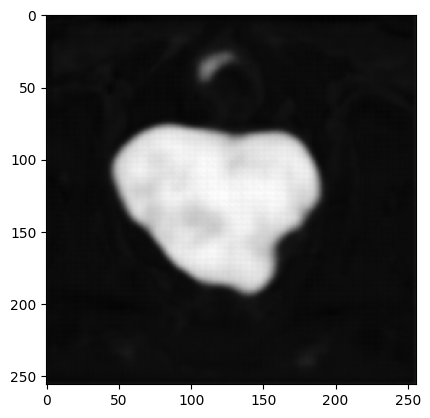

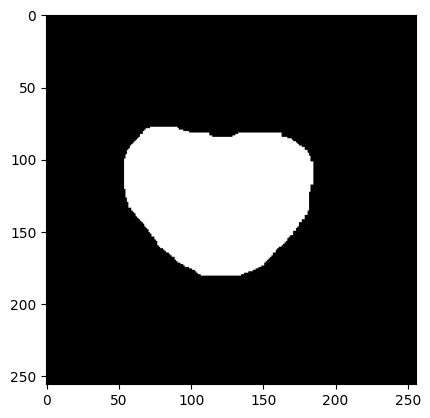

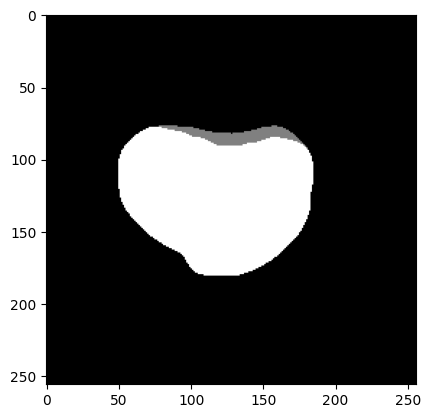

In [27]:
display_image(prediction, PATIENT_ID, name='prediction.png')
display_image(reconstruction, PATIENT_ID, name='reconstruction.png')
display_image(GT, PATIENT_ID, name='GT.png')

In [ ]:
import cv2
img1 = cv2.imread('Bean.jpg',0)
img2 = cv2.imread('saltnpepperBean.jpg',0)

diff = cv2.absdiff(img1, img2)
threshold=int(np.mean(diff))

# Make colour version of input image so we can put red pixels in it
resultRGB = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)

# Colorize all pixels above threshold with red 
resultRGB[diff>3*threshold] = 0,0,255

# Save to disk
cv2.imwrite('result.jpg',resultRGB)